# Загрузка файлов и установка необходимых библиотек

Установим модуль datasets, чтобы нам проще было работать с данными

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string
import datasets

import seaborn
seaborn.set(palette='summer')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Загрузка данных в колаб

In [3]:
%pip -q install datasets


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import datasets

dataset = datasets.load_dataset('imdb')

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

##Удалим пунктуацию и приведем текст к нижнему регистру, далее подсчитаем число встречаемости каждого слова и отсеем слова, которые встречаются редко

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

100%|██████████| 25000/25000 [00:15<00:00, 1585.60it/s]


In [7]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [8]:
len(vocab)

11399

##Сопоставим каждому символу его индекс.

In [9]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

##Обработка текстовых данных, преобразования их в числовую форму (индексы), добавление тоекнов начала и конца предложения.

In [10]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

In [11]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

##Создание валидационного датасета, "компоновка" данных в батчи для подачи в модель

In [12]:
train_dataset = WordDataset(dataset['train'])
test_dataset = WordDataset(dataset['test'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 2000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size
)

## Архитектура модели

In [13]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

## Train loop

> # evaluate

## evaluate_test (для тестирования точности модели)

In [32]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [33]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

# Обучение модели с логированием результатов в MLFlow

In [15]:
%pip -q install mlflow


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [16]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import logging


In [17]:
import mlflow
mlflow.set_tracking_uri("http://89.169.130.209:8000")
print(mlflow.get_tracking_uri())


http://89.169.130.209:8000


In [19]:
mlflow.set_experiment("new_experiment")

<Experiment: artifact_location='s3://mlflow-bucket1/artifacts', creation_time=1726651970176, experiment_id='2', last_update_time=1726651970176, lifecycle_stage='active', name='new_experiment', tags={}>

In [ ]:
import mlflow
import mlflow.pytorch

def evaluate_test(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    predictions = []
    target = []
    with torch.no_grad():
        for batch in test_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

# Обучение модели
num_epoch = 2
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    # Начало эксперимента MLflow
    with mlflow.start_run(run_name=f"CharLM-{aggregation_type}"):

        # Логирование параметров модели
        mlflow.log_param("aggregation_type", aggregation_type)
        mlflow.log_param("num_epoch", num_epoch)

        model = CharLM(
            hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(model.parameters())

        for epoch in range(num_epoch):
            epoch_losses = []
            model.train()
            for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
                optimizer.zero_grad()
                logits = model(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())
                if i % eval_steps == 0:
                    model.eval()
                    accuracy = evaluate_test(model)
                    acc.append(accuracy)
                    mlflow.log_metric(f"accuracy_epoch_{epoch}_step_{i}", accuracy)
                    model.train()

            avg_loss = sum(epoch_losses) / len(epoch_losses)
            losses.append(avg_loss)

            # Логирование потерь за эпоху
            mlflow.log_metric(f"avg_loss_epoch_{epoch}", avg_loss)

        # # Сохранение модели после обучения
        # model_path = f'charlm_model_{aggregation_type}.pth'
        # torch.save(model.state_dict(), model_path)

        # Логирование модели в MLflow
        mlflow.pytorch.log_model(model, f"models/{aggregation_type}")

        # Логирование метрик по завершению обучения
        mlflow.log_metric(f"final_accuracy_{aggregation_type}", acc[-1])

        losses_type[aggregation_type] = losses
        acc_type[aggregation_type] = acc

        print(f"Finished training for {aggregation_type}")


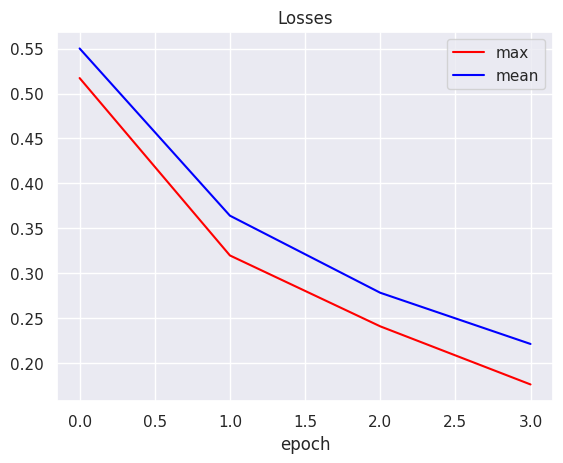

In [44]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 85.90
Лучшая accuracy для подхода mean: 85.25


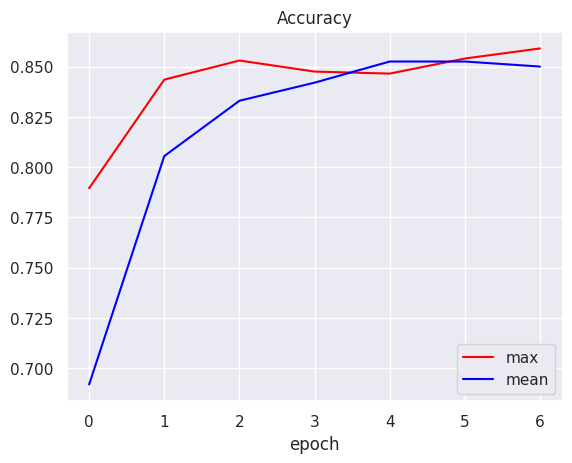

In [45]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# Оценим качество модели на тестовой выборке

In [43]:
# Загрузка модели для тестирования
model = CharLM(
    hidden_dim=256, vocab_size=len(vocab), aggregation_type='max'
).to(device)
model.load_state_dict(torch.load('charlm_model_max.pth'))
model.eval()

# Оценка модели на тестовом датасете
test_accuracy = evaluate_test(model)
print(f"Test Accuracy: {test_accuracy:.4f}")

/tmp/ipykernel_37/3833783031.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('charlm_model_max.pth'))


Test Accuracy: 0.8586
